# Using Keras to train LSTM for NER with word embeddings (together with other features with different data types)

It is possible to use dense word embeddings together with other features (e.g. POS tags) by concatenation.

This notebook shows how to train LSTM with only word embedding AND with embedding plus other features.

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import Concatenate
from keras.layers import Activation, Dropout, Dense

### Prepare Data

In [2]:
trainfile = 'data/conll2003.train.conll'
devfile = 'data/conll2003.dev.conll'
testfile = 'data/conll2003.test.conll'

In [3]:
def conll_to_dicts(conllfile):
    '''
    This function converts the .conll files into list of dicts
    '''
    data = []
    with open(conllfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token, pos, chunk, gold = components[0], components[1], components[2], components[3]
                feature_dict = {'token':token, 'pos':pos, 'chunk':chunk, 'gold':gold}
                data.append(feature_dict)
    return data

In [4]:
train_data, test_data = conll_to_dicts(trainfile), conll_to_dicts(testfile)
train_tokens, test_tokens = [dict['token'] for dict in train_data], [dict['token'] for dict in test_data]
train_gold, test_gold = [dict['gold'] for dict in train_data], [dict['gold'] for dict in test_data]

## Create vocabulary index by TextVectorization

In [ ]:
vectorizer = layers.TextVectorization()
dataset = tf.data.Dataset.from_tensor_slices(train_tokens)
vectorizer.adapt(dataset)

**Note: Fitting this vectorizor can take long. It's possible to dump it for reuse by**

In [ ]:
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()},
            open("text_vectorizer.pkl", "wb"))

And load it from disk by

In [ ]:
from_disk = pickle.load(open("text_vectorizer.pkl", "rb"))
vectorizer = layers.TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorizer.set_weights(from_disk['weights'])

See more details at https://stackoverflow.com/a/65225240

In [6]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

## Convert inputs
The gold labels ('O', 'B-LOCK', etc.) needs to be converted into integers, we can make a dictionary for that (and its reverse for mapping back)

In [7]:
def get_label_maps(label_list):
    map_dict = dict(zip(set(label_list), range(len(set(label_list)))))
    map_dict_reverse = {v: k for k, v in map_dict.items()}
    return map_dict, map_dict_reverse

label_map, label_map_reverse = get_label_maps(train_gold)

And the tokens need to be vectorized

In [ ]:
X1_train = vectorizer(train_tokens)
y_train = np.asarray([label_map[line] for line in train_gold]).astype(int)

In [9]:
X1_train

<tf.Tensor: shape=(203621, 1), dtype=int64, numpy=
array([[  996],
       [12747],
       [  203],
       ...,
       [   11],
       [ 2470],
       [   15]])>

## Create word embedding matrix with word2vec

In [10]:
import gensim.downloader
word_embedding_model = gensim.downloader.load("word2vec-google-news-300")

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [11]:
embedding_dim = 300

num_tokens = len(voc) + 2
hits, misses = 0, 0
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    try:
        embedding_vector = word_embedding_model[str(word)]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except KeyError: # the word is not found in model
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12028 words (8042 misses)


## Model 1: Using only word embeddings as feature

In [12]:
from keras.layers import Embedding
embedding_layer = Embedding(num_tokens,embedding_dim,trainable=False,)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

### Create 2 bi-LSTMs:

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         6021600   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         186880    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 6308457 (24.06 MB)
Trainable params: 286857 (

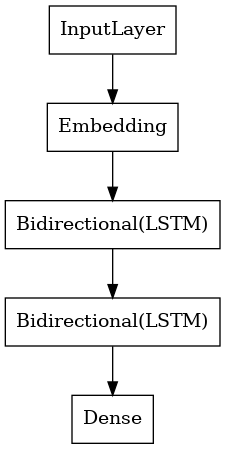

In [14]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add a classifier
outputs = Dense(9, activation='softmax')(x)

model_1 = keras.Model(int_sequences_input, outputs)
model_1.summary()
tf.keras.utils.plot_model(model_1,show_layer_names=False)

### Training:

In [16]:
model_1.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
history_0 = model_1.fit(x=X1_train, y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1273/1273 [==============================] - 14s 9ms/step - loss: 0.4884 - acc: 0.8747 - val_loss: 0.4035 - val_acc: 0.9015
Epoch 2/10
1273/1273 [==============================] - 12s 10ms/step - loss: 0.4459 - acc: 0.8856 - val_loss: 0.3843 - val_acc: 0.9048
Epoch 3/10
1273/1273 [==============================] - 10s 8ms/step - loss: 0.4298 - acc: 0.8893 - val_loss: 0.3841 - val_acc: 0.9058
Epoch 4/10
1273/1273 [==============================] - 11s 9ms/step - loss: 0.4198 - acc: 0.8921 - val_loss: 0.3725 - val_acc: 0.9079
Epoch 5/10
1273/1273 [==============================] - 11s 9ms/step - loss: 0.4120 - acc: 0.8936 - val_loss: 0.3691 - val_acc: 0.9093
Epoch 6/10
1273/1273 [==============================] - 12s 9ms/step - loss: 0.4054 - acc: 0.8949 - val_loss: 0.3731 - val_acc: 0.9094
Epoch 7/10
1273/1273 [==============================] - 11s 9ms/step - loss: 0.3994 - acc: 0.8959 - val_loss: 0.3703 - val_acc: 0.9067
Epoch 8/10
1273/1273 [==============================] 

### Testing:

In [17]:
X1_test = vectorizer(test_tokens)
y_test = np.asarray([label_map[line] for line in test_gold]).astype(int)

In [18]:
score_0 = model_1.evaluate(x=X1_test, y=y_test, verbose=1)

1452/1452 [==============================] - 5s 4ms/step - loss: 0.4651 - acc: 0.8812


In [19]:
print("Test Score:", score_0[0])
print("Test Accuracy:", score_0[1])

Test Score: 0.4650878310203552
Test Accuracy: 0.8811672329902649


## Model 2: Concatenating model 1 with more categorical features
The model 1 built above takes only word embeddings as input. To utilze other features in the dataset (POS, chunk tag), first we need to extract them

In [20]:
train_POS, test_POS = [dict['pos'] for dict in train_data], [dict['pos'] for dict in test_data]
train_chunk, test_chunk = [dict['chunk'] for dict in train_data], [dict['chunk'] for dict in test_data]

# Get int <-> classes mapping
POS_map, POS_map_reverse = get_label_maps(train_POS)
chunk_map, chunk_map_reverse = get_label_maps(train_chunk)

# Map classes to int
train_POS_num, test_POS_num = [POS_map[line] for line in train_POS], [POS_map[line] for line in test_POS]
train_chunk_num, test_chunk_num = [chunk_map[line] for line in train_chunk], [chunk_map[line] for line in test_chunk]

In [21]:
X2_class_train = np.column_stack((train_POS_num, train_chunk_num))
X2_class_test = np.column_stack((test_POS_num, test_chunk_num))

### Model building:

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            6021600   ['input_3[0][0]']             
                                                                                                  
 basic_input (InputLayer)    [(None, 2)]                  0         []                            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, None, 128)            186880    ['embedding[2][0]']           
 onal)                                                                                      

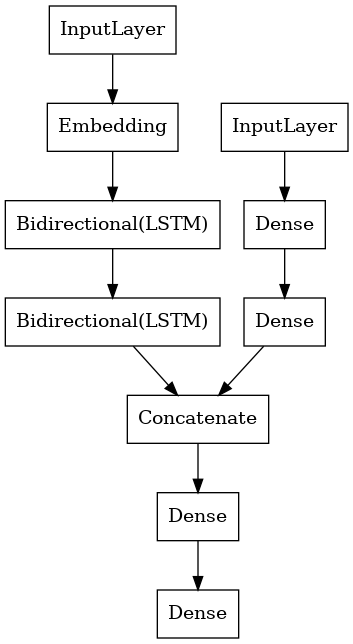

In [22]:
class_features_input = Input(shape=(2,), name='basic_input')

int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)

# 2 bidirectional LSTMs
LSTM_Layer_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedded_sequences)
LSTM_Layer_2 = layers.Bidirectional(layers.LSTM(64))(LSTM_Layer_1)

# 2 layers for class feature
dense_layer_1 = Dense(10, activation='relu')(class_features_input)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

# concat
concat_layer = Concatenate()([LSTM_Layer_2, dense_layer_2])

dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(9, activation='softmax')(dense_layer_3)
model_2 = Model(inputs=[int_sequences_input, class_features_input], outputs=output)

model_2.summary()
tf.keras.utils.plot_model(model_2,show_layer_names=False)

### Training

In [23]:
model_2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
history = model_2.fit(x=[X1_train, X2_class_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1273/1273 [==============================] - 16s 10ms/step - loss: 0.5114 - acc: 0.8572 - val_loss: 0.3458 - val_acc: 0.9008
Epoch 2/10
1273/1273 [==============================] - 13s 10ms/step - loss: 0.3448 - acc: 0.9000 - val_loss: 0.2834 - val_acc: 0.9228
Epoch 3/10
1273/1273 [==============================] - 12s 9ms/step - loss: 0.2911 - acc: 0.9167 - val_loss: 0.2569 - val_acc: 0.9295
Epoch 4/10
1273/1273 [==============================] - 11s 9ms/step - loss: 0.2719 - acc: 0.9213 - val_loss: 0.2454 - val_acc: 0.9320
Epoch 5/10
1273/1273 [==============================] - 13s 10ms/step - loss: 0.2604 - acc: 0.9247 - val_loss: 0.2410 - val_acc: 0.9339
Epoch 6/10
1273/1273 [==============================] - 12s 10ms/step - loss: 0.2516 - acc: 0.9264 - val_loss: 0.2440 - val_acc: 0.9352
Epoch 7/10
1273/1273 [==============================] - 13s 10ms/step - loss: 0.2441 - acc: 0.9284 - val_loss: 0.2341 - val_acc: 0.9367
Epoch 8/10
1273/1273 [============================

### Testing

In [24]:
score_2 = model_2.evaluate(x=[X1_test, X2_class_test], y=y_test, verbose=1)

1452/1452 [==============================] - 6s 4ms/step - loss: 0.2939 - acc: 0.9149


In [25]:
print("Test Score:", score_2[0])
print("Test Accuracy:", score_2[1])

Test Score: 0.2939097583293915
Test Accuracy: 0.9149132966995239


## Evaluation of the two models

In [26]:
predictions_1 = model_1.predict(x=X1_test)

1452/1452 [==============================] - 4s 2ms/step


In [27]:
predictions_2 = model_2.predict(x=[X1_test,X2_class_test])

1452/1452 [==============================] - 4s 2ms/step


In [28]:
perdict_label_1 = [label_map_reverse[line] for line in np.argmax(predictions_1,axis=1)]
perdict_label_2 = [label_map_reverse[line] for line in np.argmax(predictions_2,axis=1)]

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

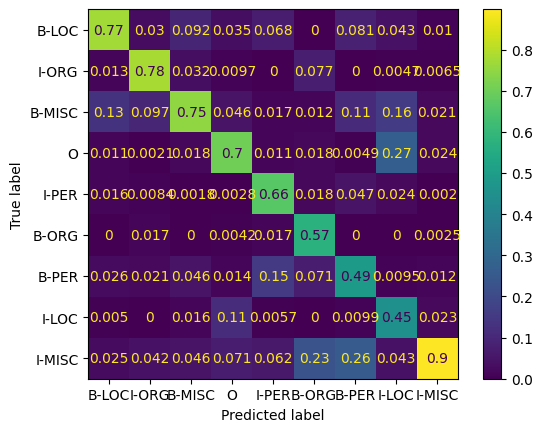

In [30]:
cf_matrix_1 = confusion_matrix(test_gold, perdict_label_1, normalize = 'pred')
matrix_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix_1, display_labels = set(train_gold))
matrix_display.plot()

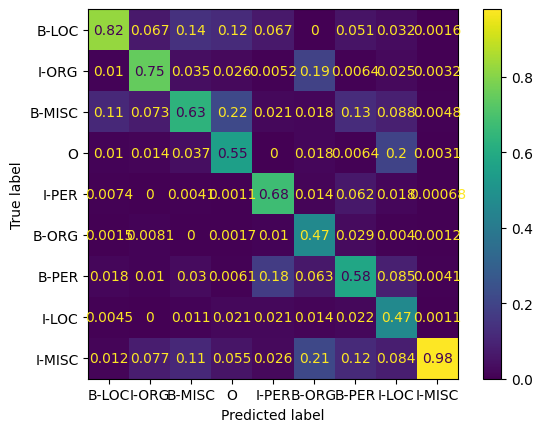

In [31]:
cf_matrix_2 = confusion_matrix(test_gold, perdict_label_2, normalize = 'pred')
matrix_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix_2, display_labels = set(train_gold))
matrix_display.plot()

### Save models: You can do this by model.save()